In [1]:
!pip install keras-tuner

In [2]:
!pip install tensorflow

In [3]:
#importing all the necessary libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import xgboost as xgb
from scipy.signal import welch
from scipy.stats import entropy
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import layers
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from kerastuner.tuners import RandomSearch

warnings.filterwarnings('ignore')

<ipython-input-3-66d52ae88ba2>:24: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch


# Data Preprocessing

#### Download and extract the datasets.

In [4]:


# Specify the folder path where your text files are stored
folder_path = 'Project_3'

# Initialize an empty list to store data
data = []

# Loop through each file in the folder
for filename in os.listdir(folder_path):
    if filename.lower().endswith(".txt"):
        # Read the data from the file
        file_path = os.path.join(folder_path, filename)
        with open(file_path, 'r') as file:
            # Read the content of the file and split it into samples
            content = file.read().split()
            # Convert ASCII data to integers (assuming each sample is a single integer)
            samples = [int(value) for value in content]
            # Append the data to the list with the filename as the first element
            data.append([filename] + samples)

# Create a DataFrame from the list of data
column_names = ['Filename'] + [f'Sample_{i}' for i in range(1, 4098)]  # Assuming 4096 samples
df = pd.DataFrame(data, columns=column_names)


# # Create a new column based on the condition
# df['file_code'] = df['Filename'].apply(encode_filename)


# Display the DataFrame
print(df)


     Filename  Sample_1  Sample_2  Sample_3  Sample_4  Sample_5  Sample_6  \
0    F022.txt        26        29        26        22        18         8   
1    Z099.txt        56        55        38        -5       -47       -72   
2    O093.txt       -83      -120      -123      -119       -93       -45   
3    Z007.txt        -2        20        42        48        27        11   
4    F032.txt        46        41        44        39        42        41   
..        ...       ...       ...       ...       ...       ...       ...   
495  N062.TXT        -1         1        -1         5        -1        -3   
496  O086.txt       -40       -19       -38       -71       -76       -86   
497  Z050.txt        81        68        35         5        -6         6   
498  Z044.txt       -46       -44       -47       -40       -21         4   
499  S047.txt       -10      -658     -1254     -1395      -977      -198   

     Sample_7  Sample_8  Sample_9  ...  Sample_4088  Sample_4089  Sample_40

The above dataset contains 500 rows and 4100 columns after extracting and encoding.

#### Explore the data to understand its structure and characteristics.

In [5]:
#displaying information about the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Columns: 4098 entries, Filename to Sample_4097
dtypes: int64(4097), object(1)
memory usage: 15.6+ MB


In [6]:
#displaying statistics of the dataset
df.describe()

,Sample_1,Sample_2,Sample_3,Sample_4,Sample_5,Sample_6,Sample_7,Sample_8,Sample_9,Sample_10,...,Sample_4088,Sample_4089,Sample_4090,Sample_4091,Sample_4092,Sample_4093,Sample_4094,Sample_4095,Sample_4096,Sample_4097
count,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,...,500.000000,500.00000,500.000000,500.000000,500.00000,500.000000,500.000000,500.000000,500.000000,500.000000
mean,-3.718000,-9.802000,-16.094000,-18.820000,-16.662000,-12.124000,-6.510000,-2.142000,1.882000,4.438000,...,-5.706000,-4.05600,-2.632000,-1.928000,-2.03800,-1.184000,0.928000,1.132000,-0.770000,-18.544000
std,145.274622,163.176469,188.246611,201.245888,188.973686,165.080719,153.637922,155.370054,155.850617,155.882831,...,184.588736,172.97619,166.175453,167.097438,177.47457,181.666176,173.855683,148.916496,119.354128,216.793244
min,-985.000000,-1221.000000,-1406.000000,-1395.000000,-1291.000000,-880.000000,-998.000000,-1156.000000,-1009.000000,-665.000000,...,-1583.000000,-1224.00000,-1094.000000,-1400.000000,-1697.00000,-1547.000000,-1120.000000,-1073.000000,-734.000000,-1852.000000
25%,-48.250000,-54.000000,-52.000000,-52.250000,-53.000000,-57.250000,-55.000000,-56.000000,-58.250000,-57.000000,...,-52.000000,-48.25000,-47.000000,-48.250000,-51.00000,-56.250000,-56.250000,-48.250000,-48.000000,-54.000000
50%,-8.000000,-8.000000,-7.000000,-9.000000,-8.500000,-7.000000,-5.000000,-7.000000,-5.000000,-5.000000,...,-9.000000,-9.50000,-7.000000,-9.500000,-6.50000,-7.000000,-5.000000,-5.000000,-4.500000,-11.000000
75%,36.000000,36.250000,37.250000,38.000000,41.000000,40.000000,38.250000,36.000000,36.000000,32.250000,...,31.000000,32.00000,34.000000,39.000000,41.25000,42.000000,46.000000,39.000000,31.250000,30.000000
max,800.000000,839.000000,857.000000,876.000000,893.000000,928.000000,973.000000,1045.000000,1381.000000,1502.000000,...,925.000000,911.00000,914.000000,919.000000,916.00000,829.000000,781.000000,703.000000,677.000000,1002.000000


### If necessary, preprocess the EEG data, including handling missing values, noise reduction, and data augmentation.

#### Encoding the labels based on the file names

In [7]:
def encode_filename(value):
    if 'F' in value:
        return 1
    elif 'N' in value:
        return 2
    elif 'O' in value:
        return 3
    elif 'S' in value:
        return 4
    elif 'Z' in value:
        return 5

# Create a file_code based on the Filename
df['file_code'] = df['Filename'].apply(encode_filename)

## Encoding the file set based on the file names

- File set has been taken from the official website

In [8]:
def encode_filename_get_set(value):
    if 'F' in value:
        return 'D'
    elif 'N' in value:
        return 'C'
    elif 'O' in value:
        return 'B'
    elif 'S' in value:
        return 'E'
    elif 'Z' in value:
        return 'A'

# Create a file_set based on the Filename
df['file_set'] = df['Filename'].apply(encode_filename_get_set)

#### Encoding the data colletion and recording techniques given in the official paper

In [9]:
def encode_filename_get_recording_technique(value):
    if 'F' in value:
        return 'Epileptogenic Zone : Seizure Free'
    elif 'N' in value:
        return 'Hippocampal Formation : Seizure Free'
    elif 'O' in value:
        return 'Eyes Closed : Seizure Free'
    elif 'S' in value:
        return 'Seizure Activity'
    elif 'Z' in value:
        return 'Eyes Open : Seizure Free'

# Create a file_set based on the Filename
df['recording_technique'] = df['Filename'].apply(encode_filename_get_recording_technique)

### Bringing the categorical values to the begining

In [10]:
col = df.columns.tolist()
col = [col[0]] + col [-3:] + col[1:-3]
df = df[col]
df.head()

,Filename,file_code,file_set,recording_technique,Sample_1,Sample_2,Sample_3,Sample_4,Sample_5,Sample_6,...,Sample_4088,Sample_4089,Sample_4090,Sample_4091,Sample_4092,Sample_4093,Sample_4094,Sample_4095,Sample_4096,Sample_4097
0,F022.txt,1,D,Epileptogenic Zone : Seizure Free,26,29,26,22,18,8,...,53,55,62,60,63,69,65,49,32,-150
1,Z099.txt,5,A,Eyes Open : Seizure Free,56,55,38,-5,-47,-72,...,-44,-3,36,41,14,-27,-45,-32,-4,69
2,O093.txt,3,B,Eyes Closed : Seizure Free,-83,-120,-123,-119,-93,-45,...,72,21,-22,-31,-18,-3,-5,-27,-50,-38
3,Z007.txt,5,A,Eyes Open : Seizure Free,-2,20,42,48,27,11,...,-3,7,-3,-17,-38,-38,-23,-18,-6,-37
4,F032.txt,1,D,Epileptogenic Zone : Seizure Free,46,41,44,39,42,41,...,50,17,-28,-63,-76,-88,-92,-84,-75,-102


### Checking missing values

In [11]:
df.isnull().sum()

Filename               0
file_code              0
file_set               0
recording_technique    0
Sample_1               0
                      ..
Sample_4093            0
Sample_4094            0
Sample_4095            0
Sample_4096            0
Sample_4097            0
Length: 4101, dtype: int64

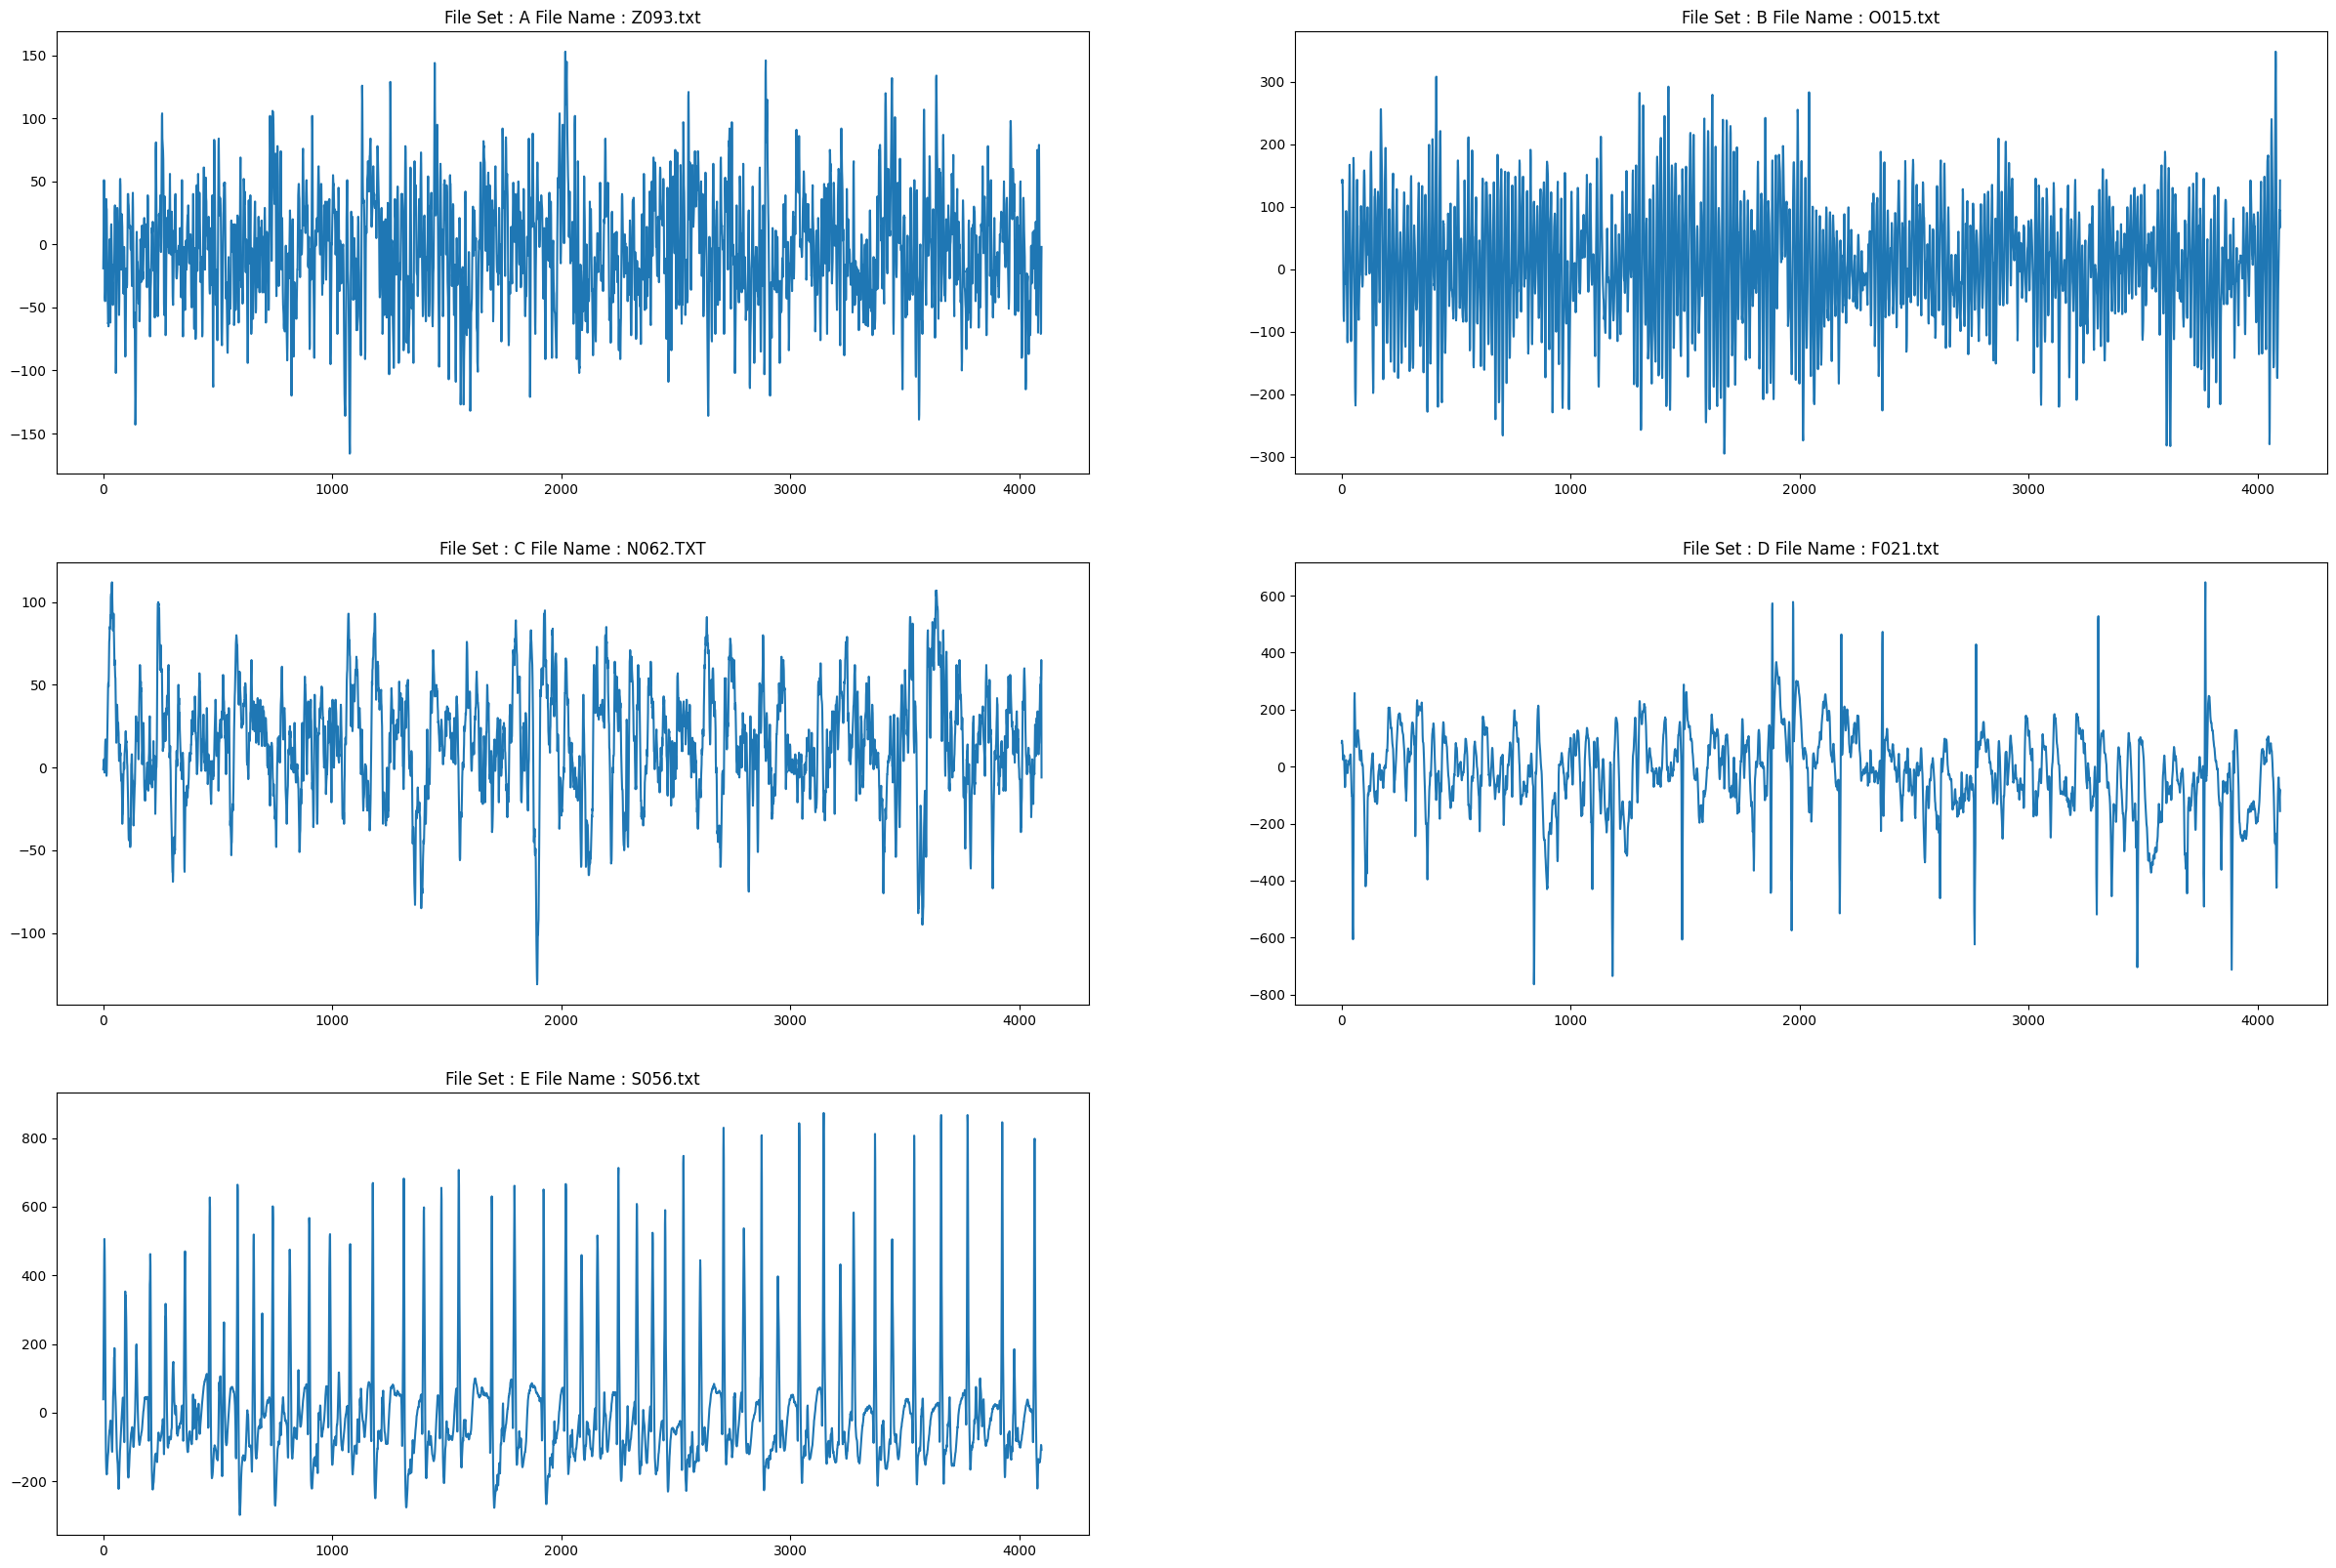

In [12]:
#displaying sample EEG graph from each set
plt.figure(figsize= (30,20))

plt.subplot(3,2,1)
file_name = 'Z093.txt'
set_code = df[df['Filename'] == file_name].iloc[0,2]

x = [i for i in range(1,4098)]
y = df[df['Filename'] == file_name].iloc[0,4:]

plt.title(f'File Set : {set_code} File Name : {file_name}')
plt.plot(x, y )

plt.subplot(3,2,2)

file_name = 'O015.txt'
set_code = df[df['Filename'] == file_name].iloc[0,2]

x = [i for i in range(1,4098)]
y = df[df['Filename'] == file_name].iloc[0,4:]

plt.title(f'File Set : {set_code} File Name : {file_name}')
plt.plot(x, y )

plt.subplot(3,2,3)
file_name = 'N062.TXT'
set_code = df[df['Filename'] == file_name].iloc[0,2]

x = [i for i in range(1,4098)]
y = df[df['Filename'] == file_name].iloc[0,4:]

plt.title(f'File Set : {set_code} File Name : {file_name}')
plt.plot(x, y )

plt.subplot(3,2,4)
file_name = 'F021.txt'
set_code = df[df['Filename'] == file_name].iloc[0,2]

x = [i for i in range(1,4098)]
y = df[df['Filename'] == file_name].iloc[0,4:]

plt.title(f'File Set : {set_code} File Name : {file_name}')
plt.plot(x, y )


plt.subplot(3,2,5)
file_name = 'S056.txt'
set_code = df[df['Filename'] == file_name].iloc[0,2]

x = [i for i in range(1,4098)]
y = df[df['Filename'] == file_name].iloc[0,4:]

plt.title(f'File Set : {set_code} File Name : {file_name}')
plt.plot(x, y )

From the samples timeseries from each set, it can be observed that  
A and B looks normal  
C has occasional spikes  
D has more occasional spikes  
where as E has very high number of hikes  

There is a chance that Set E contains the values during Seizure

The folders Contains numerous .txt files, each likely representing an individual EEG recording or data file. Each .txt file in these folders probably contains EEG data points. The sample data from each folder ('Z', 'S', 'F', 'N', 'O') appears to be in a similar format. Given this structure, it seems that each file represents a single EEG recording, with each row likely corresponding to a signal measurement at a specific time point. The data is univariate, meaning each file contains measurements from a single EEG channel or a specific feature extracted from the EEG signal.

All the files have the same number of samples (4,097), which indicates a consistency in data collection or recording length. However, the range of values and the mean values vary significantly between files. Such variations are expected in EEG data, as they reflect different brain activities and possibly different conditions (such as epileptic seizures versus normal brain function).

Each .txt file is encoded into 4097 samples and all F.txt files are coded as 1, N as 2, O as 3, S as 4, Z as 5. File set has also be named to F as D, N as C, O as B, S as E, Z as A.  

After performing all the steps the totals rows are set to be 500 and columns are 4100.

# Feature Extraction

#### Extract relevant features from the EEG signals. You may consider time-domain and frequency-domain features.

### Extracting Time Domain Features

In [13]:
def extract_features_time_domain(signal):
    # Time-domain features
    mean_value = np.mean(signal)
    variance = np.var(signal)
    rms_value = np.sqrt(np.mean(signal**2))
    std_dev = np.std(signal)

    return [mean_value, variance, rms_value, std_dev]

# Apply the function to each row in the DataFrame
feature_columns = ['mean', 'variance', 'rms', 'std_dev']

# Create a new DataFrame for features
feature_df = pd.DataFrame(columns=['file_name', 'file_code', 'file_set'] + feature_columns)

# Iterate through rows in the original DataFrame
for index, row in df.iterrows():
    file_name = row['Filename']
    file_code = row['file_code']
    file_set = row['file_set']
    eeg_signal = row.iloc[4:]  # Assuming the EEG signal starts from the second column

    # Extract features from the EEG signal
    features = [file_name]+ [file_code] + [file_set] + extract_features_time_domain(eeg_signal)

    # Append the features to the new DataFrame
    feature_df = feature_df.append(pd.Series(features, index=feature_df.columns), ignore_index=True)

# Display the new DataFrame
feature_df

,file_name,file_code,file_set,mean,variance,rms,std_dev
0,F022.txt,1,D,-16.655846,4874.638209,71.777820,69.818609
1,Z099.txt,5,A,-14.893581,2028.057506,47.432860,45.033959
2,O093.txt,3,B,9.191848,4411.932440,67.055369,66.422379
3,Z007.txt,5,A,-13.334635,2139.935127,48.142991,46.259433
4,F032.txt,1,D,-19.669758,6750.543857,84.483390,82.161693
...,...,...,...,...,...,...,...
495,N062.TXT,2,C,14.933122,1061.053375,35.833664,32.573814
496,O086.txt,3,B,-50.073468,3692.213055,78.737318,60.763583
497,Z050.txt,5,A,3.820356,2488.566703,50.031608,49.885536
498,Z044.txt,5,A,3.562119,1957.717950,44.389263,44.246107


### Extracting Frequency Domain Features

In [14]:
def calculate_psd(row, fs):
    """ Calculate the Power Spectral Density (PSD) for a row. """
    freqs, psd = welch(row, fs)
    return freqs, psd

def calculate_peak_frequency(row, fs):
    """ Find the peak frequency. """
    freqs, psd = calculate_psd(row, fs)
    peak_freq = freqs[np.argmax(np.abs(psd))]
    return peak_freq

def bandpower(row, fs, band):
    """ Calculate the Band Power within a specific frequency band for a row. """
    freqs, psd = welch(row, fs)
    psd_abs = np.abs(psd)  # Use the absolute value of the PSD
    band_freqs = np.logical_and(freqs >= band[0], freqs <= band[1])
    band_power = np.trapz(psd_abs[band_freqs], freqs[band_freqs])
    return band_power


fs = 173.61  # Sampling rate (in Hz)

# Initialize lists to store the features
peak_frequencies = []
delta_powers = []
theta_powers = []
alpha_powers = []
beta_powers = []
gamma_powers = []

# Iterate over each row in the DataFrame
for index, row in df.iterrows():
    # Calculate each feature
    peak_freq = calculate_peak_frequency(row[4:], fs)
    delta = bandpower(row[4:], fs, [0.5, 4])
    theta = bandpower(row[4:], fs, [4, 8])
    alpha = bandpower(row[4:], fs, [8, 13])
    beta = bandpower(row[4:], fs, [13, 30])
    gamma = bandpower(row[4:], fs, [30, 45])

    # Append the features to the lists
    peak_frequencies.append(peak_freq)
    delta_powers.append(delta)
    theta_powers.append(theta)
    alpha_powers.append(alpha)
    beta_powers.append(beta)
    gamma_powers.append(gamma)

# Add the features as new columns to the DataFrame
feature_df['Peak_Frequency'] = peak_frequencies
feature_df['Delta_Power'] = delta_powers
feature_df['Theta_Power'] = theta_powers
feature_df['Alpha_Power'] = alpha_powers
feature_df['Beta_Power'] = beta_powers
feature_df['Gamma_Power'] = gamma_powers

# Now df has the original data along with the new frequency domain features
feature_df

,file_name,file_code,file_set,mean,variance,rms,std_dev,Peak_Frequency,Delta_Power,Theta_Power,Alpha_Power,Beta_Power,Gamma_Power
0,F022.txt,1,D,-16.655846,4874.638209,71.777820,69.818609,1.356328,3320.813346,449.318424,393.029683,140.679575,4.291224
1,Z099.txt,5,A,-14.893581,2028.057506,47.432860,45.033959,0.678164,396.343234,312.443404,485.336957,470.613815,14.318553
2,O093.txt,3,B,9.191848,4411.932440,67.055369,66.422379,11.528789,474.041195,446.161776,2208.933118,608.938744,17.895372
3,Z007.txt,5,A,-13.334635,2139.935127,48.142991,46.259433,0.678164,493.876892,286.862642,550.402647,418.776916,15.901065
4,F032.txt,1,D,-19.669758,6750.543857,84.483390,82.161693,0.678164,2205.736373,729.659136,531.871816,376.481452,13.511676
...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,N062.TXT,2,C,14.933122,1061.053375,35.833664,32.573814,1.356328,571.895175,141.127870,87.234560,46.254712,3.363693
496,O086.txt,3,B,-50.073468,3692.213055,78.737318,60.763583,13.563281,438.644054,557.372320,923.177402,1106.018251,20.444900
497,Z050.txt,5,A,3.820356,2488.566703,50.031608,49.885536,0.678164,700.090973,283.666064,455.052457,303.418894,10.969719
498,Z044.txt,5,A,3.562119,1957.717950,44.389263,44.246107,0.678164,509.261613,315.749318,338.584501,343.513656,17.987084


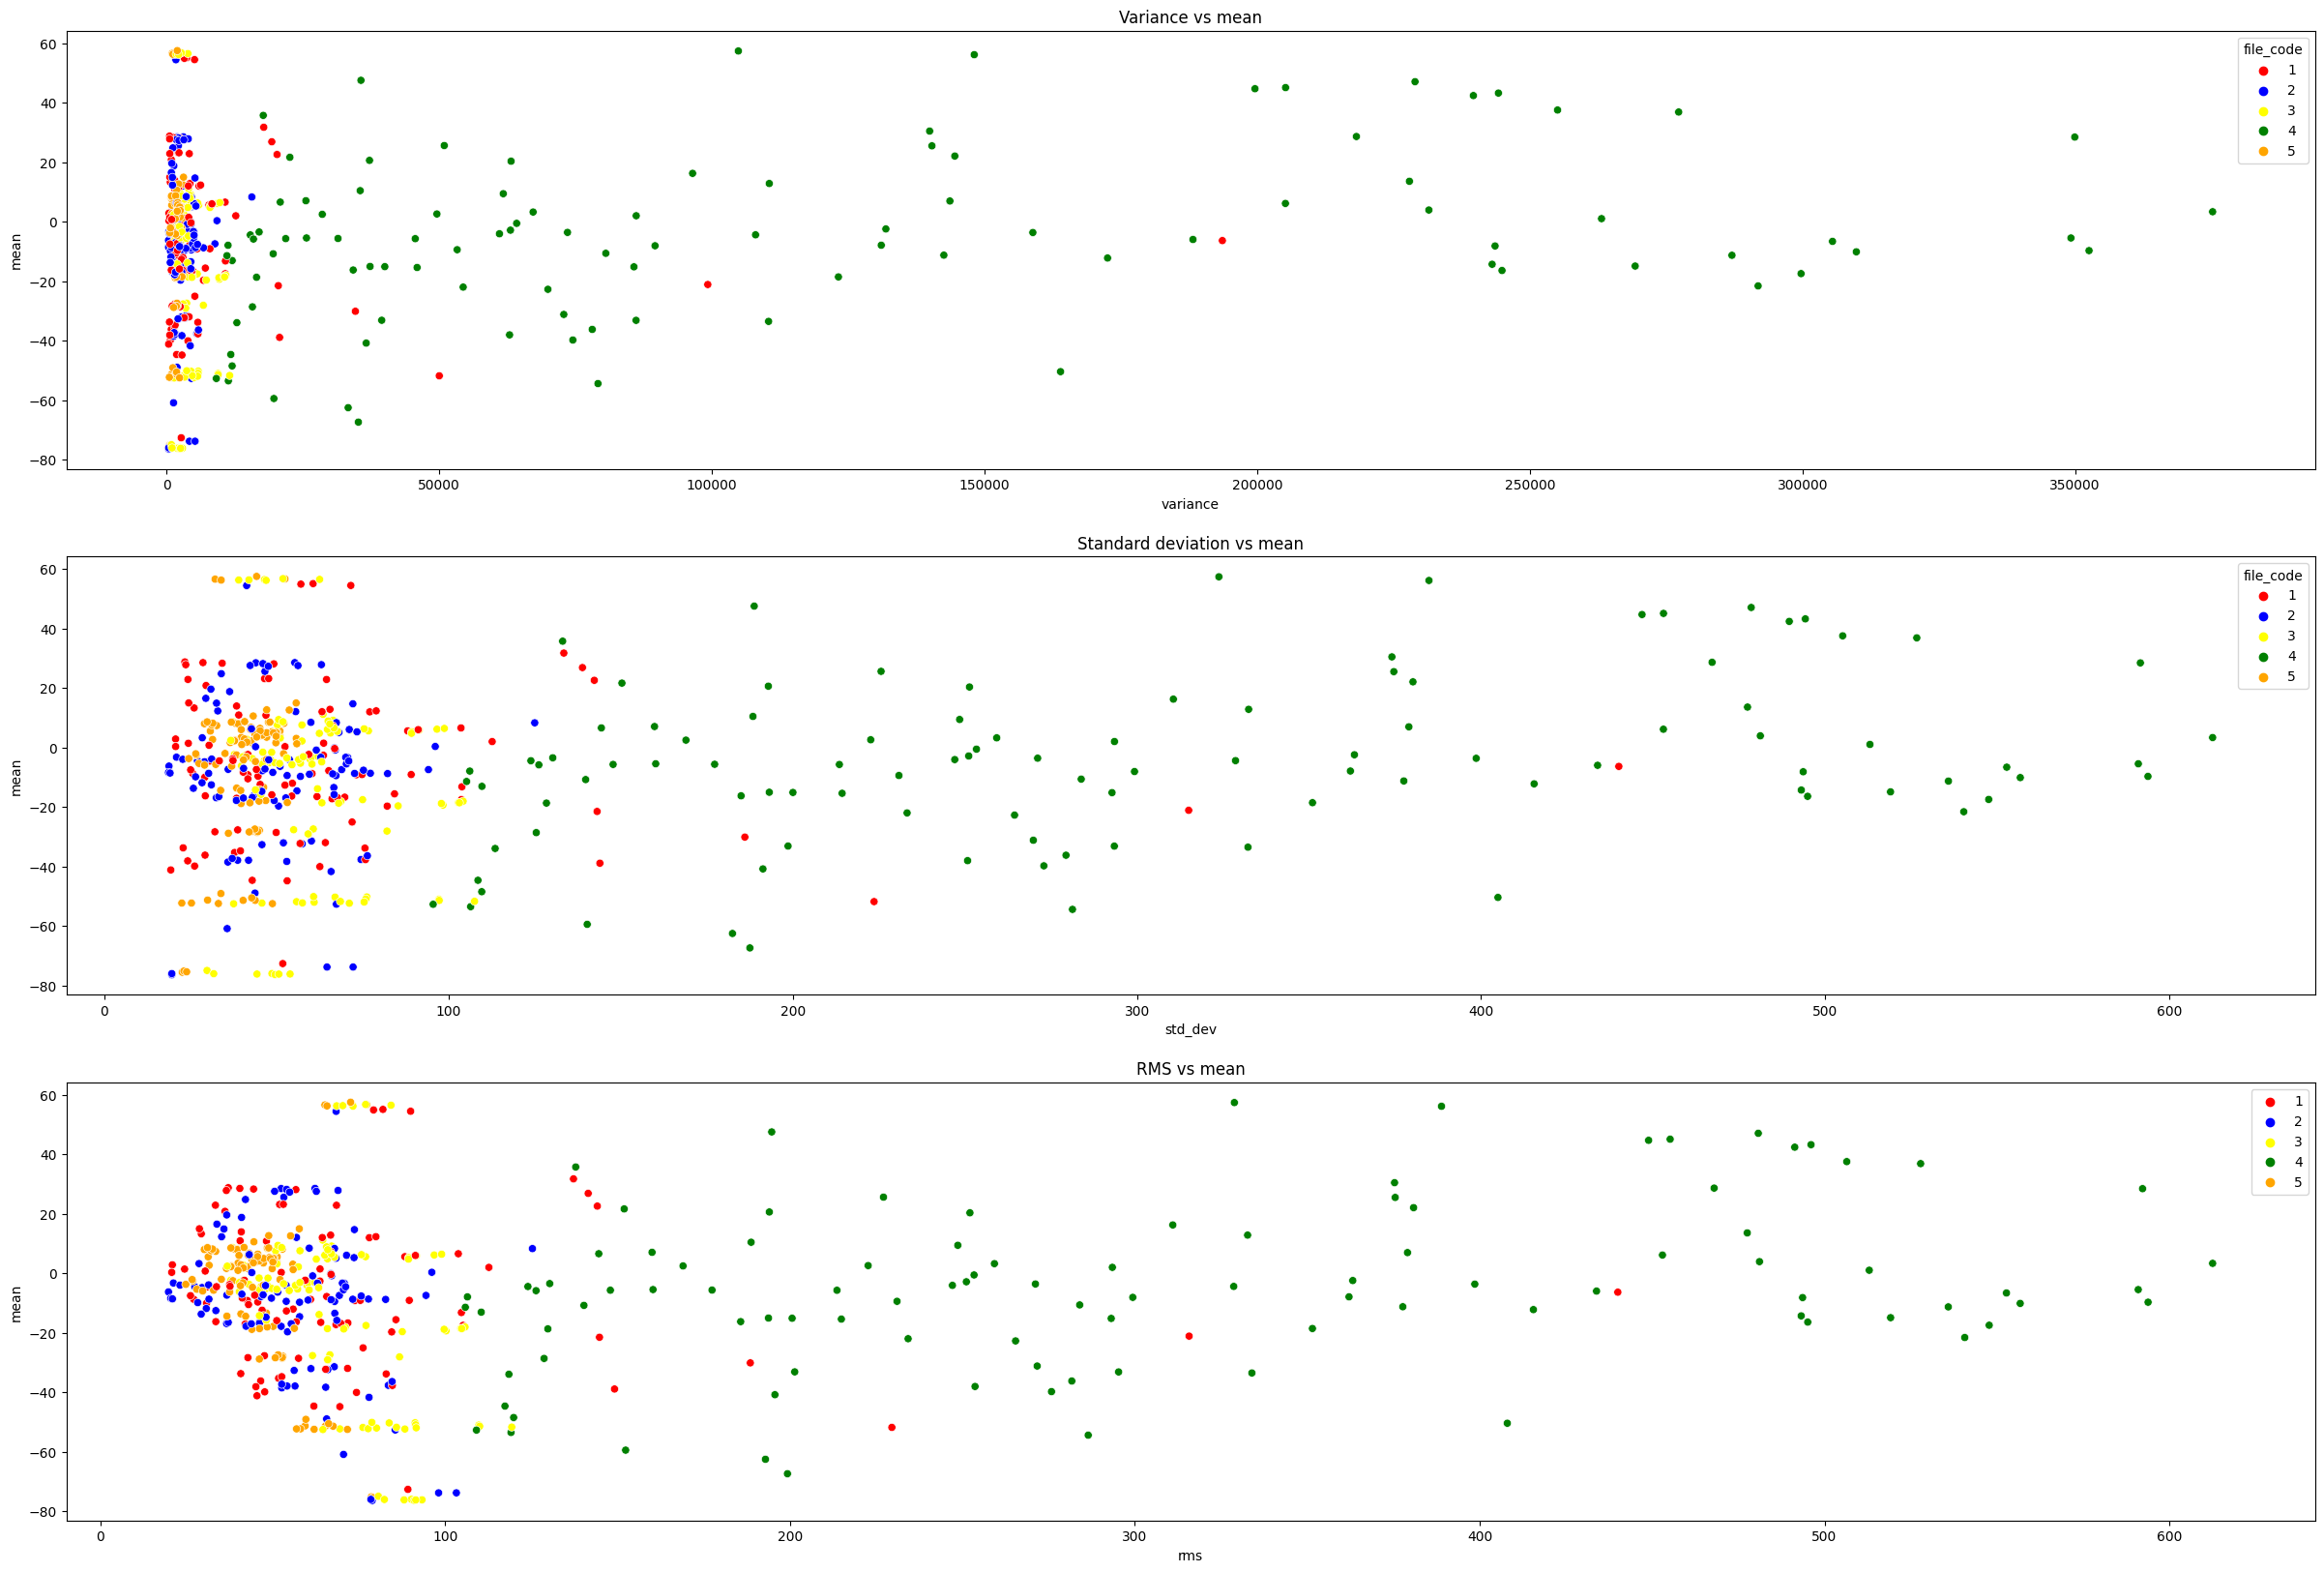

In [15]:
plt.figure(figsize=(30,20))
plt.subplot(3,1,1)
sns.scatterplot(x='variance', y = 'mean', data = feature_df, hue = 'file_code', palette=['red', 'blue', 'yellow', 'green',  'orange'])
plt.title("Variance vs mean")

plt.subplot(3,1,2)
sns.scatterplot(x='std_dev', y = 'mean', data = feature_df, hue = 'file_code', palette=['red', 'blue','yellow', 'green', 'orange'])
plt.title("Standard deviation vs mean")

plt.subplot(3,1,3)
sns.scatterplot(x='rms', y = 'mean', data = feature_df, hue = 'file_code', palette=['red', 'blue', 'yellow', 'green', 'orange'])
plt.title("RMS vs mean")

plt.legend()
plt.show()

From the Above graphs based on time based features it can be observed that values of Set S differ from all others significantly, Set D values has occasionally differ from other.

From the given paper:  
Volunteers
were relaxed in an awake state with eyes open ~A! and eyes
closed ~B!, respectively. Sets C, D, and E originated from our
EEG archive of presurgical diagnosis. For the present study
EEGs from five patients were selected, all of whom had
achieved complete seizure control after resection of one of
the hippocampal formations, which was therefore correctly
diagnosed to be the epileptogenic zone ~cf. Segments
in set D were recorded from within the epileptogenic zone,
and those in set C from the hippocampal formation of the
opposite hemisphere of the brain. While sets C and D contained only activity measured during seizure free intervals,
set E only contained seizure activity. Here segments were
selected from all recording sites exhibiting ictal activity.

Hence it is given that Set E has been collected during activity and it can also be observed in the above charts. Labelling the rows from Set E as 1 indicating it is a seizure.

In [16]:
# Function to check if 'S' is present in the value
def labelling(value):
    if 'E' in value:
        return 1
    else:
        return 0


# Create a new column based on the condition
df['label'] = df['file_set'].apply(labelling)
feature_df['label'] = feature_df['file_set'].apply(labelling)
df

,Filename,file_code,file_set,recording_technique,Sample_1,Sample_2,Sample_3,Sample_4,Sample_5,Sample_6,...,Sample_4089,Sample_4090,Sample_4091,Sample_4092,Sample_4093,Sample_4094,Sample_4095,Sample_4096,Sample_4097,label
0,F022.txt,1,D,Epileptogenic Zone : Seizure Free,26,29,26,22,18,8,...,55,62,60,63,69,65,49,32,-150,0
1,Z099.txt,5,A,Eyes Open : Seizure Free,56,55,38,-5,-47,-72,...,-3,36,41,14,-27,-45,-32,-4,69,0
2,O093.txt,3,B,Eyes Closed : Seizure Free,-83,-120,-123,-119,-93,-45,...,21,-22,-31,-18,-3,-5,-27,-50,-38,0
3,Z007.txt,5,A,Eyes Open : Seizure Free,-2,20,42,48,27,11,...,7,-3,-17,-38,-38,-23,-18,-6,-37,0
4,F032.txt,1,D,Epileptogenic Zone : Seizure Free,46,41,44,39,42,41,...,17,-28,-63,-76,-88,-92,-84,-75,-102,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,N062.TXT,2,C,Hippocampal Formation : Seizure Free,-1,1,-1,5,-1,-3,...,35,40,50,49,50,55,53,65,-6,0
496,O086.txt,3,B,Eyes Closed : Seizure Free,-40,-19,-38,-71,-76,-86,...,-51,-64,-72,-68,-60,-59,-46,-41,-63,0
497,Z050.txt,5,A,Eyes Open : Seizure Free,81,68,35,5,-6,6,...,38,33,29,23,20,12,15,10,17,0
498,Z044.txt,5,A,Eyes Open : Seizure Free,-46,-44,-47,-40,-21,4,...,1,20,32,38,40,48,43,56,14,0


# Data Splitting

### Split the data into training, validation, and test sets.

In [17]:
# Assuming feature_df is your DataFrame with features
# 'file_name' column is dropped as it's not used for training
X = feature_df[['mean', 'variance', 'rms', 'std_dev','Peak_Frequency', 'Delta_Power','Theta_Power','Alpha_Power', 'Beta_Power', 'Gamma_Power']].values
y = feature_df['label'].values

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=40, stratify=y)

# Model Selection and Model Training and Model Evaluation with Hyper Parameter Tuning.

## Training the Random Forest Model

- Hyper parameter tuning is being performed using Grid Search CV

- Class weights has been calculated to balance the imbalance in the data

## Calculate the weights as follows:

- Weight for class 0 = Total Instances / (Number of Classes * Instances in Class 0) = 500 / (2 * 400) = 0.625
- Weight for class 1 = Total Instances / (Number of Classes * Instances in Class 1) = 500 / (2 * 100) = 2.5

In [18]:
#Random Forest
# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 4, 6],
    'min_samples_leaf': [1, 2, 3]
}

# Create a RandomForest model
rf = RandomForestClassifier(random_state=42, class_weight={0: 0.625, 1: 2.5})

# Set up GridSearchCV
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, scoring='accuracy')

# Perform grid search
grid_search.fit(X_train, y_train)

# Best parameters and best score
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best score: {grid_search.best_score_}")

# Use the best estimator for making predictions
best_rf = grid_search.best_estimator_



Best parameters: {'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best score: 0.9800000000000001


# Training the XgBoost Model

- Hyper parameter tuning is being performed using Grid Search CV

- Imbalance in the data has been dealt using scale_pos_weight

In [19]:
#XGBoost

# Define the parameter grid
param_grid = {
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200, 300],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

# Create a XGBClassifier model
xgb_model = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    random_state=42,
    scale_pos_weight=4  # Set the scale_pos_weight parameter as in your original model
)

# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    cv=5,
    n_jobs=-1,
    scoring='accuracy'
)

# Perform grid search
grid_search.fit(X_train, y_train)

# Best parameters and best score
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best score: {grid_search.best_score_}")

# Use the best estimator for making predictions
best_xgb = grid_search.best_estimator_


Best parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 200, 'subsample': 0.9}
Best score: 0.9825000000000002


# Training the RNN Model

- Hyper parameter tuning is being performed using Kears Tuner

- Class weights has been calculated to balance the imbalance in the data

- RNN creates a set of Validation set from training set and calculates the validation loss and validation accuracy

In [20]:
#RNN with keras tuner

def build_model(hp):
    model = Sequential()
    model.add(SimpleRNN(units=hp.Int('units', min_value=32, max_value=128, step=32),
                        input_shape=(X_train.shape[1], 1),
                        activation='relu',
                        return_sequences=True))
    model.add(Dropout(rate=hp.Float('dropout', min_value=0.2, max_value=0.5, step=0.1)))
    model.add(SimpleRNN(units=hp.Int('units', min_value=32, max_value=128, step=32),
                        activation='relu'))
    model.add(Dropout(rate=hp.Float('dropout', min_value=0.2, max_value=0.5, step=0.1)))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer=Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model
class_weight = {0 : 0.625, 1: 2.5}
# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Define the Keras Tuner RandomSearch
tuner = RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=5,  # You can increase this based on your computational resources
    directory='keras_tuner_dir',
    project_name='rnn_hyperparameter_tuning'
)

# Search for the best hyperparameters
tuner.search(X_train, y_train, epochs=200, batch_size=32, validation_split=0.2, callbacks=[early_stopping], class_weight = class_weight)

# Get the best hyperparameters
rnn_best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best Hyperparameters:", rnn_best_hps)

# Build the final model with the best hyperparameters
rnn_final_model = tuner.hypermodel.build(rnn_best_hps)
rnn_final_model.summary()

# Train the final model
rnn_final_model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2)


Reloading Tuner from keras_tuner_dir/rnn_hyperparameter_tuning/tuner0.json
Best Hyperparameters: <keras_tuner.src.engine.hyperparameters.hyperparameters.HyperParameters object at 0x782f3ff34940>
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 10, 32)            1088      
                                                                 
 dropout (Dropout)           (None, 10, 32)            0         
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 32)                2080      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                           

In the process of selecting an appropriate model for our project, careful consideration was given to the size and nature of our dataset. With an initial dataset consisting of 500 samples, each with 4097 features, preprocessing efforts have resulted in a more streamlined dataset of 500 samples with only 4 features. This reduction in dimensionality raises concerns about the suitability of certain models, particularly Convolutional Neural Networks (CNNs). CNNs are renowned for their efficacy in handling image data with inherent spatial relationships, often represented as 2D grids. Given the transformed nature of our dataset, which lacks the grid-like structure associated with images, opting for a model tailored to tabular data or simpler structures appears more prudent.

# Model Evaluation and Testing

In [21]:
# Evaluation Metric

evaluation_df = pd.DataFrame(columns=['Model', 'Accuray', "Precision", 'Recall', 'F1 Score'])

# Predictions on test data
rf_y_pred = best_rf.predict(X_test)

# Efficiency metrics
rf_accuracy = accuracy_score(y_test, rf_y_pred)
rf_precision = precision_score(y_test, rf_y_pred)
rf_recall = recall_score(y_test, rf_y_pred)
rf_f1 = f1_score(y_test, rf_y_pred)
rf_conf_matrix = confusion_matrix(y_test, rf_y_pred)

new_row = {'Model': 'Random Forest', 'Accuray': rf_accuracy, 'Precision' : rf_precision, 'Recall' : rf_recall, 'F1 Score' : rf_f1}
evaluation_df = evaluation_df.append(new_row, ignore_index= True)


# Predictions on test data
xgb_y_pred = best_xgb.predict(X_test)

# Efficiency metrics
xgb_accuracy = accuracy_score(y_test, xgb_y_pred)
xgb_precision = precision_score(y_test, xgb_y_pred)
xgb_recall = recall_score(y_test, xgb_y_pred)
xgb_f1 = f1_score(y_test, xgb_y_pred)
xgb_conf_matrix = confusion_matrix(y_test, xgb_y_pred)

new_row = {'Model': 'XgBoost', 'Accuray': xgb_accuracy, 'Precision' : xgb_precision, 'Recall' : xgb_recall, 'F1 Score' : xgb_f1}
evaluation_df = evaluation_df.append(new_row, ignore_index= True)


 # Evaluate the final model on test data
rnn_y_pred_probs = rnn_final_model.predict(X_test)
rnn_y_pred = (rnn_y_pred_probs > 0.5).astype(int)

# Efficiency metrics
rnn_accuracy = accuracy_score(y_test, rnn_y_pred)
rnn_precision = precision_score(y_test, rnn_y_pred)
rnn_recall = recall_score(y_test, rnn_y_pred)
rnn_f1 = f1_score(y_test, rnn_y_pred)
rnn_conf_matrix = confusion_matrix(y_test, rnn_y_pred)

new_row = {'Model': 'RNN', 'Accuray': rnn_accuracy, 'Precision' : rnn_precision, 'Recall' : rnn_recall, 'F1 Score' : rnn_f1}
evaluation_df = evaluation_df.append(new_row, ignore_index= True)



print("\nEvaluaion Metrics on Test Data \n")
display(evaluation_df)

4/4 [==============================] - 0s 4ms/step

Evaluaion Metrics on Test Data 



,Model,Accuray,Precision,Recall,F1 Score
0,Random Forest,0.99,0.952381,1.0,0.975610
1,XgBoost,0.97,0.947368,0.9,0.923077
2,RNN,0.99,0.952381,1.0,0.975610


 The Random Forest model shows exceptional performance with an accuracy of 99% and a perfect recall of 1.00, indicating its proficiency in identifying all relevant cases. Its F1 score of approximately 0.976 suggests a strong balance between precision and recall. The XgBoost model, with an accuracy of 97% and an F1 score of around 0.923, also performs admirably, balancing precision and recall effectively. Lastly, the RNN model, while matching the 97% accuracy of XgBoost, stands out with a perfect precision of 1.00, though its recall is slightly lower at 0.85, as reflected in its F1 score of approximately 0.919.

# Results and Visualization

### Visualize the EEG data and model predictions. Create plots and graphs to illustrate your findings.

# Visualizing the F1 Score

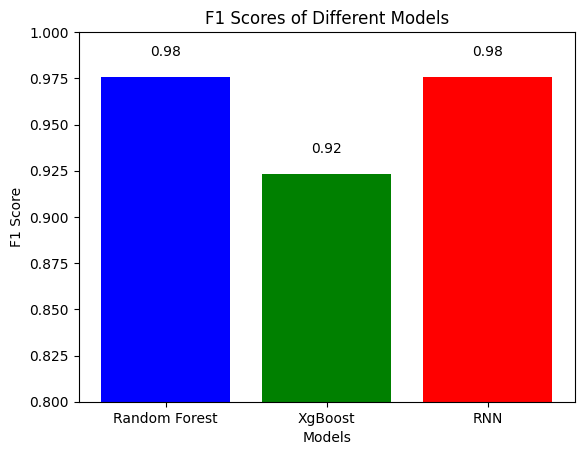

In [22]:

# F1 scores for each model
models = ['Random Forest', 'XgBoost', 'RNN']
scores = [rf_f1, xgb_f1, rnn_f1]

# Creating the bar chart
plt.bar(models, scores, color=['blue', 'green', 'red'])

# Annotating the F2 scores on the bars
for i, score in enumerate(scores):
    plt.text(i, score + 0.01, f'{score:.2f}', ha='center', va='bottom')

# Adjusting the y-axis limits
plt.ylim(0.8, 1)

# Adding title and labels
plt.title('F1 Scores of Different Models')
plt.xlabel('Models')
plt.ylabel('F1 Score')

# Display the chart
plt.show()


 Random Forest and RNN have high scores around 0.98, while XgBoost has a slightly lower score of 0.92. The accompanying text indicates strong performance in precision-recall trade-off for the Random Forest and XgBoost models, with RNN slightly behind. With Random Forest and RNN outperforming XgBoost, all scoring above 0.90, indicating a high level of precision and recall in their performance.

# Visualizing the confusion matrix of different models

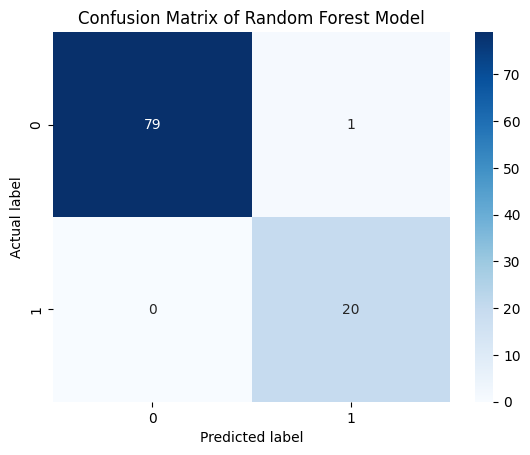

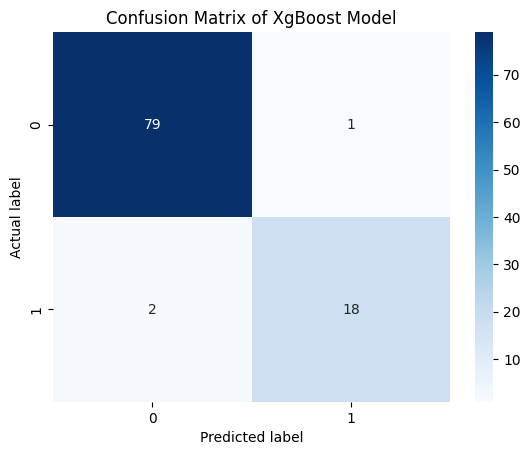

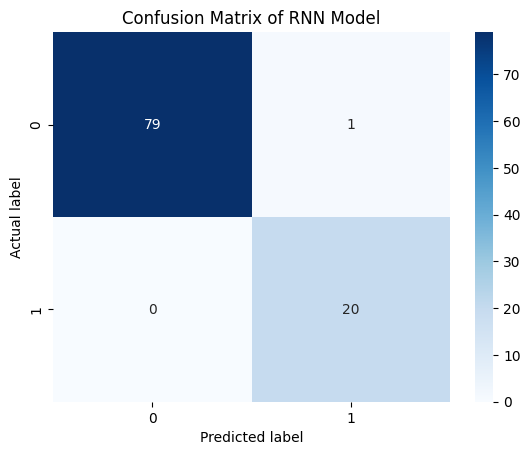

In [23]:

# Creating the heatmap
sns.heatmap(rf_conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['0', '1'],
            yticklabels=['0', '1'])

# Adding title and labels
plt.title('Confusion Matrix of Random Forest Model')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

# Display the heatmap
plt.show()

# Creating the heatmap
sns.heatmap(xgb_conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['0', '1'],
            yticklabels=['0', '1'])

# Adding title and labels
plt.title('Confusion Matrix of XgBoost Model')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

# Display the heatmap
plt.show()

# Creating the heatmap
sns.heatmap(rnn_conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['0', '1'],
            yticklabels=['0', '1'])

# Adding title and labels
plt.title('Confusion Matrix of RNN Model')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

# Display the heatmap
plt.show()

Random Forest, XgBoost, and RNN, as part of a binary classification task. All three models show a significant number of true positives (79) and true negatives (20 for Random Forest and RNN, 18 for XgBoost), with very few false negatives and false positives, indicating high performance. The Random Forest and RNN models have no false negatives, while the XgBoost model has two. These results suggest that the Random Forest and RNN models are slightly better at correctly classifying both positive and negative classes than XgBoost in this particular task. These matrices underscore the models' robustness in correctly classifying the majority of the test data.

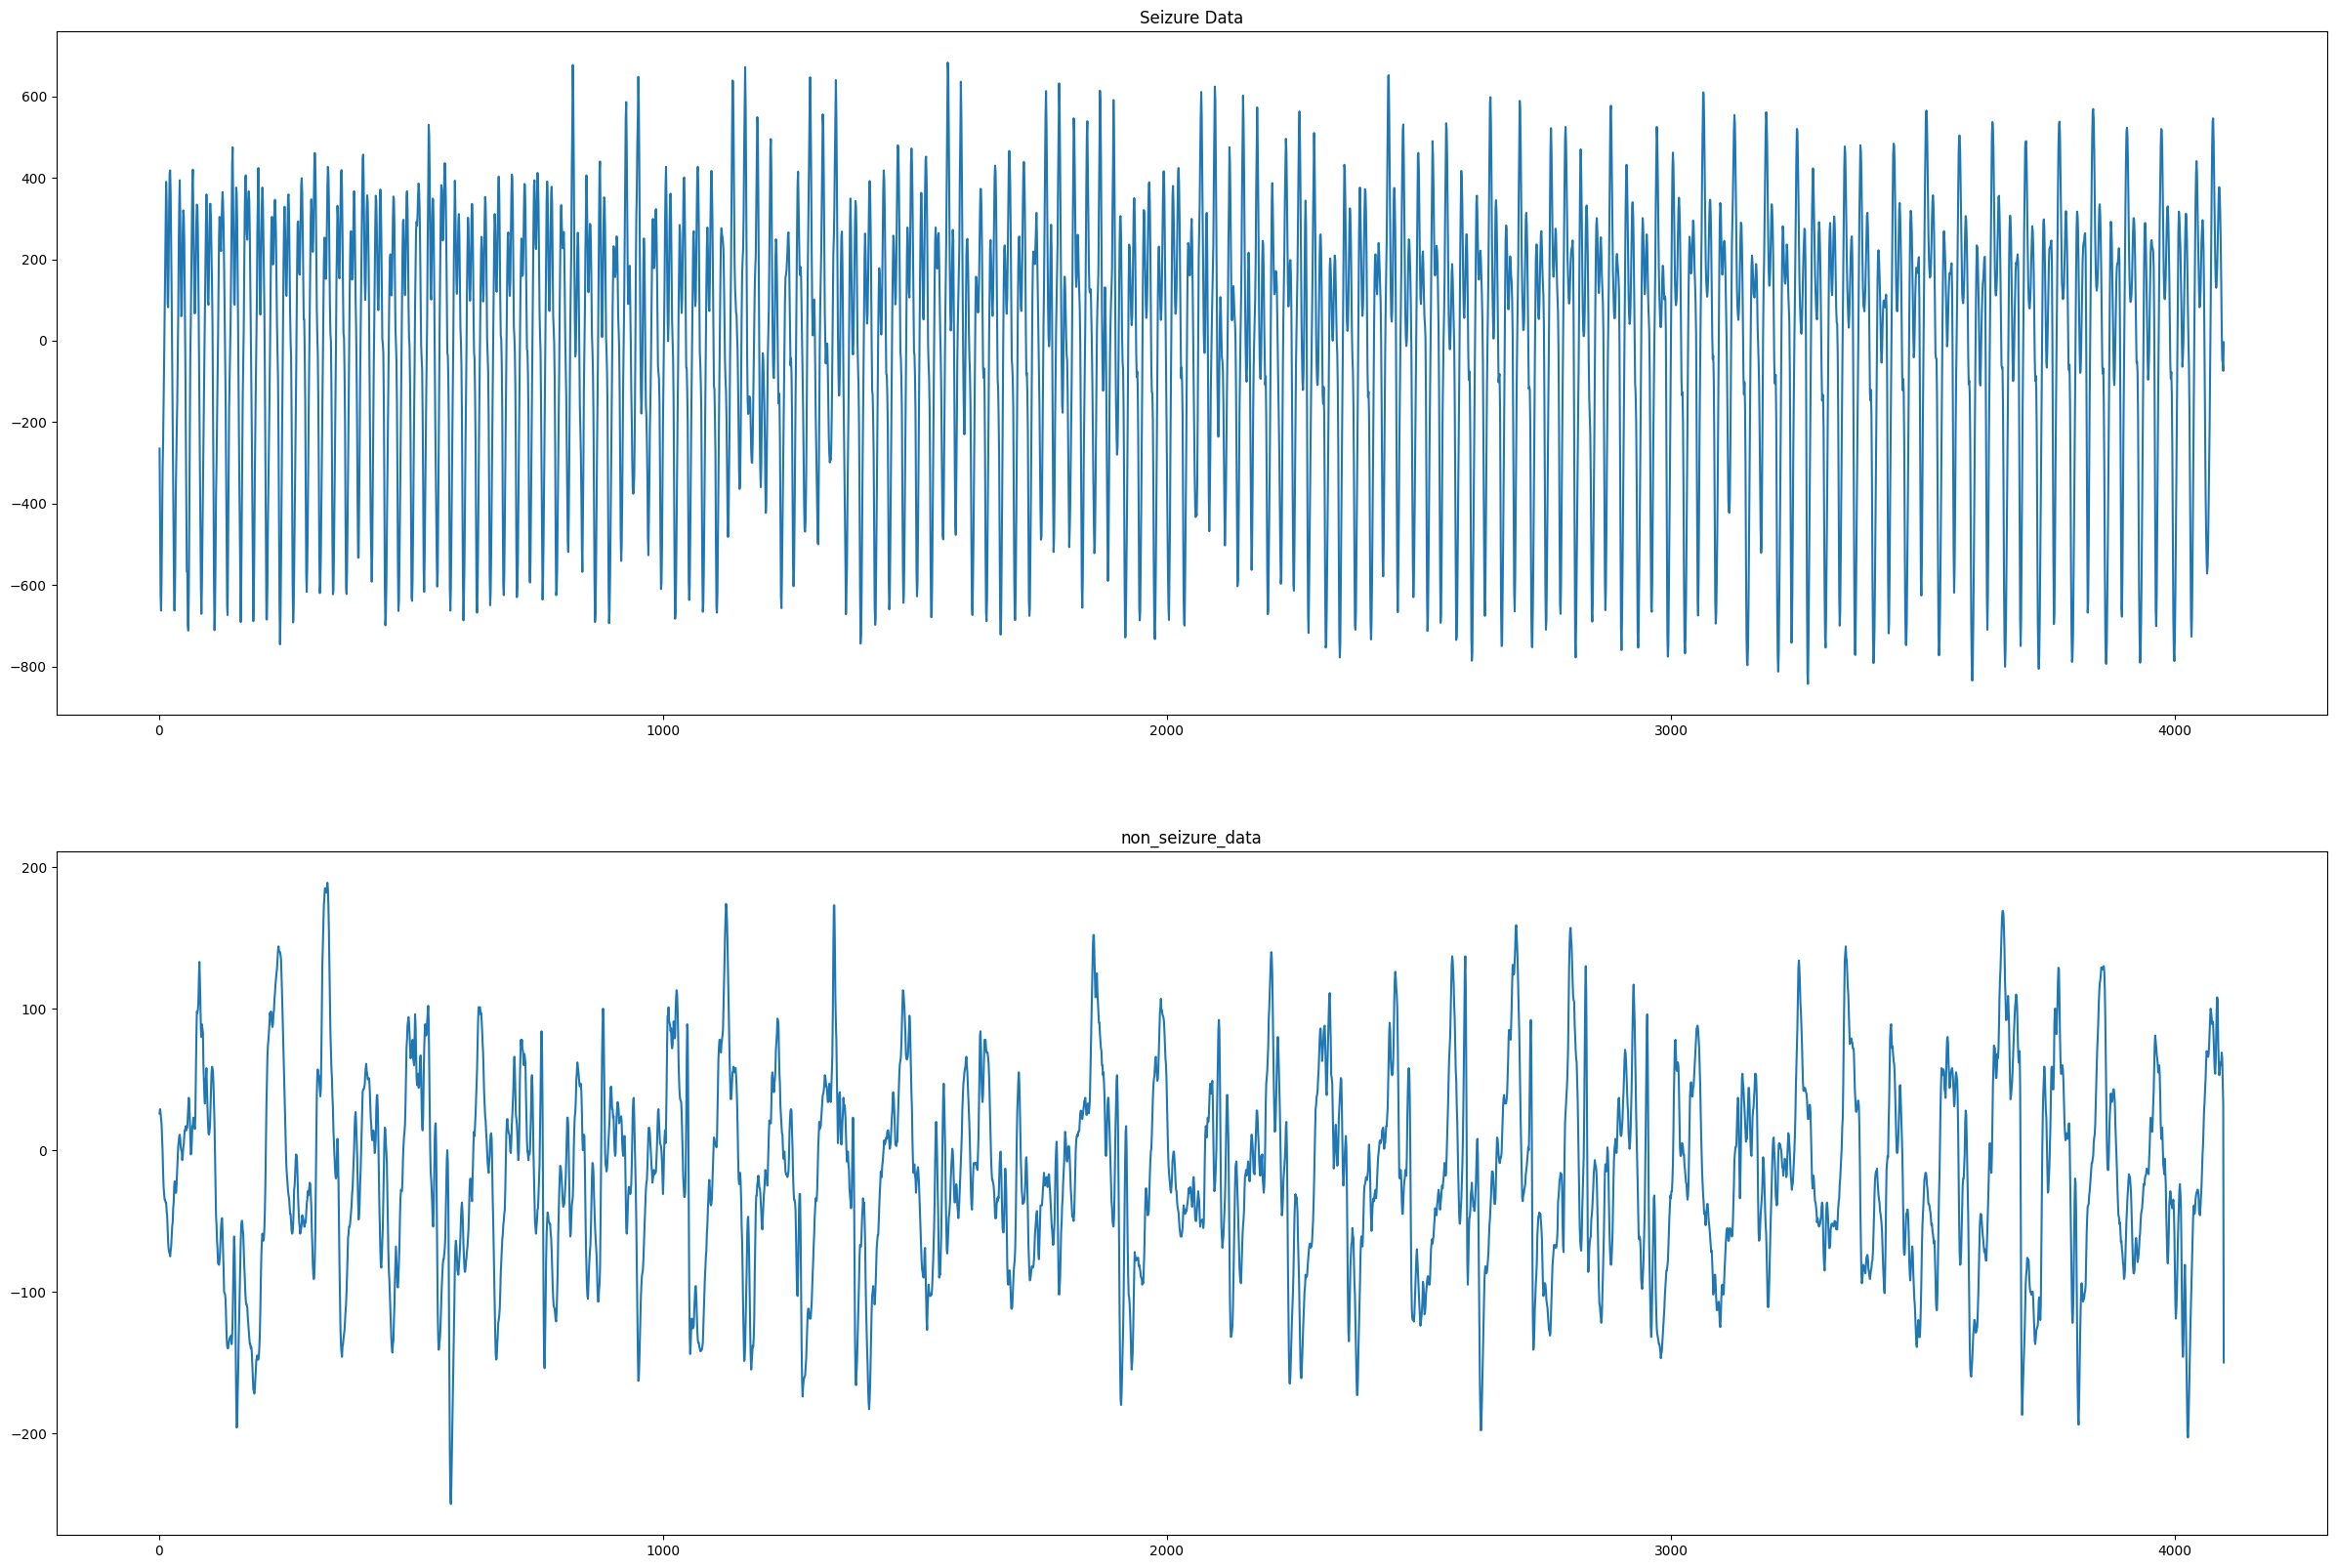

In [24]:
#visualising EEG data
seizure_data = df[df['label'] == 1].iloc[0,4:-1].tolist()
non_seizure_data = df[df['label'] == 0].iloc[0,4:-1].tolist()

plt.figure(figsize= (30,20))

plt.subplot(2,1,1)

x = [i for i in range(1,4098)]
y = seizure_data

plt.title(f'Seizure Data')
plt.plot(x, y )

plt.subplot(2,1,2)

x = [i for i in range(1,4098)]
y = non_seizure_data

plt.title(f'non_seizure_data')
plt.plot(x, y )

plt.show()

# Multi Class Classification

- As random forest has performed best in the binary classification of Seizure or non seizure data.
- Random forest has been used for multi class clasification to classify data to multi classes bases on the EEG data

Best parameters: {'max_depth': 7, 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 100}
Best score: 0.8275
Accuracy: 0.8200
Precision: 0.8294
Recall: 0.8200
F1 Score: 0.8154


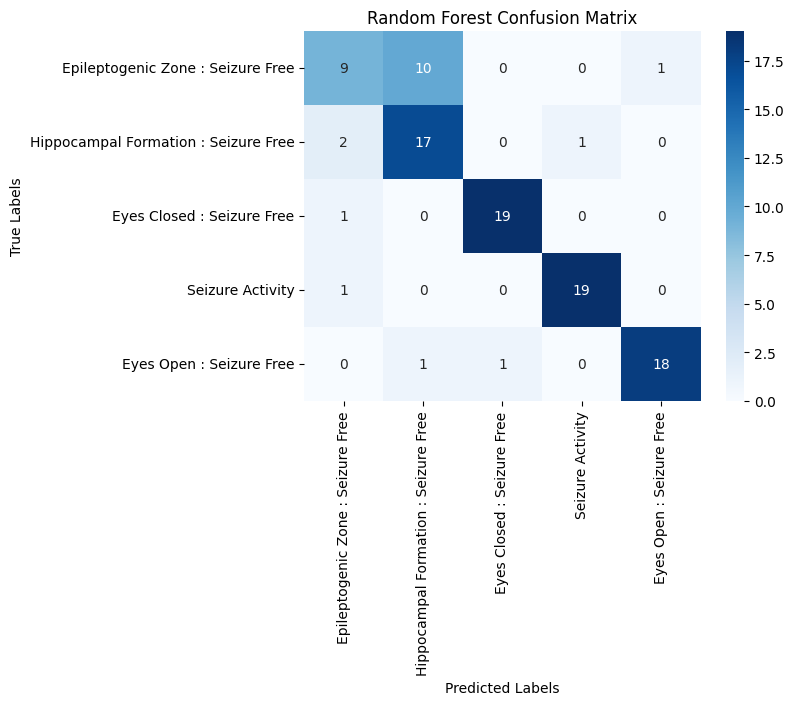

In [26]:
# Assuming feature_df is your DataFrame with features
# 'file_name' column is dropped as it's not used for training
X = feature_df[['mean', 'variance', 'rms', 'std_dev','Peak_Frequency', 'Delta_Power','Theta_Power','Alpha_Power', 'Beta_Power', 'Gamma_Power']].values
y = df['file_code'].values

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=40, stratify=y)

#Random Forest
# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 4, 6],
    'min_samples_leaf': [1, 2, 3]
}

# Create a RandomForest model
rf = RandomForestClassifier(random_state=42)

# Set up GridSearchCV
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, scoring='accuracy')

# Perform grid search
grid_search.fit(X_train, y_train)

# Best parameters and best score
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best score: {grid_search.best_score_}")

# Use the best estimator for making predictions
best_rf = grid_search.best_estimator_

# Predictions on test data
rf_y_pred = best_rf.predict(X_test)

# Efficiency metrics
rf_accuracy = accuracy_score(y_test, rf_y_pred)
rf_precision = precision_score(y_test, rf_y_pred, average='weighted')
rf_recall = recall_score(y_test, rf_y_pred, average='weighted')
rf_f1 = f1_score(y_test, rf_y_pred, average='weighted')
rf_conf_matrix = confusion_matrix(y_test, rf_y_pred)

print(f'Accuracy: {rf_accuracy:.4f}')
print(f'Precision: {rf_precision:.4f}')
print(f'Recall: {rf_recall:.4f}')
print(f'F1 Score: {rf_f1:.4f}')

# Define class labels
class_labels = ['Epileptogenic Zone : Seizure Free', 'Hippocampal Formation : Seizure Free', 'Eyes Closed : Seizure Free', 'Seizure Activity', 'Eyes Open : Seizure Free']

# Plot the confusion matrix using Seaborn heatmap
sns.heatmap(rf_conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Random Forest Confusion Matrix')
plt.show()

The Random Forest model, used for multi-class classification of EEG data, leveraged features like mean and power bands. After standardizing the data, the model was fine-tuned using GridSearchCV. This resulted in an accurate classifier capable of differentiating between various brain activity states. The effectiveness of the model was demonstrated through a confusion matrix.






